In [40]:
import numpy as np
import h5py
import pickle
import scipy
import scipy.io as sio
from pyriemann.utils.mean import mean_covariance
import sklearn.datasets
import sklearn.decomposition
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [10]:
def get_data():
    '''
    Extracts FCs for each parcellation and stores into a dictionary of dictionaries
    '''
    all_parc = {}
    # Yeo ordering
    for p in np.arange(100,600,100):
        temp_parc = {}
        filename = f'../data/FC_all_vec_424_schaefer_subc_{p}.mat'
        f = h5py.File(filename, 'r')
        for k, v in f.items():
            temp_parc[k] = np.array(v)
        all_parc[p] = temp_parc
    return all_parc


def q1invm(q1, eig_thresh=0):
    U, S, V = scipy.linalg.svd(q1)
    s = np.diag(S)
    s[s < eig_thresh] = eig_thresh
    S = np.diag(s ** (-1 / 2))
    Q1_inv_sqrt = U * S * np.transpose(V)
    Q1_inv_sqrt = (Q1_inv_sqrt + np.transpose(Q1_inv_sqrt)) / 2
    return Q1_inv_sqrt


def qlog(q):
    U, S, V = scipy.linalg.svd(q)
    s = np.diag(S)
    S = np.diag(np.log(s))
    Q = U * S * np.transpose(V)
    return Q


def tangential(all_FC, ref):
    # Regularization for riemann
    if ref in ['riemann', 'kullback_sym', 'logeuclid']:
        print("Adding regularization!")
        eye_mat = np.eye(all_FC.shape[1])
        scaling_mat = np.repeat(eye_mat[None, ...], all_FC.shape[0], axis=0)
        all_FC += scaling_mat
    Cg = mean_covariance(all_FC, metric=ref)
    Q1_inv_sqrt = q1invm(Cg)
    Q = Q1_inv_sqrt @ all_FC @ Q1_inv_sqrt
    tangent_FC = np.array([qlog(a) for a in Q])
    return tangent_FC

def pca_recon(FC, pctComp=None):
    '''
    Reconstructs FC based on number of principle components
    '''
    if pctComp is None:
        return FC
    FC = np.reshape(FC, (FC.shape[0], -1))
    nComp = int(FC.shape[0] * pctComp)
    mu = np.mean(FC, axis=0)
    pca_rest = sklearn.decomposition.PCA()
    pca_rest.fit(FC)
    SCORES = pca_rest.transform(FC)[:, :nComp]
    COEFFS = pca_rest.components_[:nComp, :]
    FC_recon = np.dot(SCORES, COEFFS)
    del SCORES, COEFFS
    FC_recon += mu
    FC_recon = np.reshape(FC_recon, (FC.shape[0], 374, 374))
    return FC_recon

def utri2mat(utri):
    n = int(-1 + np.sqrt(1 + 8 * len(utri))) // 2
    iu1 = np.tril_indices(n+1,-1)
    ret = np.empty((n+1, n+1))
    ret[iu1] = utri
    ret.T[iu1] = utri
    np.fill_diagonal(ret, 1)
    return ret, n+1

def mat2utri(mat):
    n = mat.shape[0]
    iu1 = np.tril_indices(n,-1)
    utri = mat[iu1]
    return utri
    
   

In [3]:
with open('../data/schaefer100.pickle', 'rb') as f:
    all_FC = pickle.load(f)

In [4]:
nSubj = int(all_FC.shape[0]/16)
nFCs = int(all_FC.shape[0])
classifier = 'task'
if classifier == 'task':
    labels = np.tile(np.repeat(np.arange(0, 8), nSubj), 2)
    indices = np.random.permutation(nSubj)
    train_idx = indices[:int(0.80 * nSubj)]
    test_idx = indices[int(0.8 * nSubj):]
    train_idx_all, test_idx_all = np.empty(0, dtype=int), np.empty(0, dtype=int)
    for fc in np.arange(0, 16):
        train_idx_all = np.concatenate((train_idx_all, (fc * nSubj) + train_idx)).astype(int)
        test_idx_all = np.concatenate((test_idx_all, (fc * nSubj) + test_idx)).astype(int)
    train_idx = train_idx_all
    test_idx = test_idx_all
elif classifier == 'subject':
    labels = np.tile(np.tile(np.arange(0,nSubj),8),2)
    indices = np.random.permutation(all_FC.shape[0])
    train_idx = indices[:int(0.80 * all_FC.shape[0])]
    test_idx = indices[int(0.80 * all_FC.shape[0]):]
else:
    pass

train_labels = labels[train_idx]
test_labels = labels[test_idx]

In [8]:
accuracies = {}

array([100, 200, 300])

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

for parc in np.arange(100, 200, 100):
    print(f'Using Schaefer {parc} parcellation...')
    for ref in ['euclid', 'none']:
        with open(f'../data/schaefer{parc}.pickle', 'rb') as f:
            all_FC = pickle.load(f)
        # Start with a fresh batch of FCs
        if ref != 'none':
            all_FC = tangential(all_FC, ref)
        else:
            pass
        # Convert back into flattened utriu vectors
        vec_FCs = np.zeros((nFCs,6441), dtype=np.float32)
        for idx, mat in enumerate(all_FC):
            vec_FCs[idx] = mat2utri(mat)
        # Split into train and test sets
        train_FCs = vec_FCs[train_idx]
        test_FCs = vec_FCs[test_idx]
        # KNN Classifier
        print(f'Testing {ref}...')
        neigh = KNeighborsClassifier(n_neighbors=5, metric='cosine')
        neigh.fit(train_FCs, train_labels)
        predicted = neigh.predict(test_FCs)
        acc = accuracy_score(test_labels, predicted)
        print(acc)
        accuracies[f"{ref}_{parc}"] = acc

Using Schaefer 100 parcellation...
Testing euclid...
0.25
Testing none...
0.7588235294117647


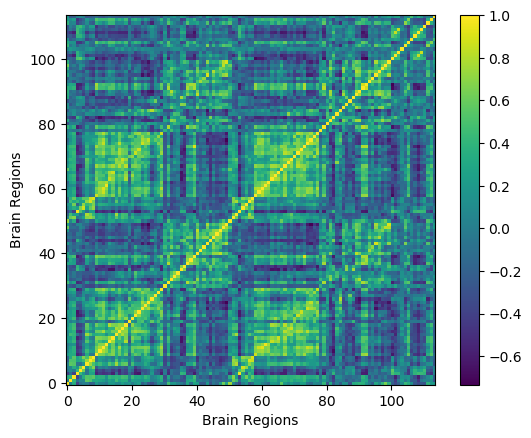

In [46]:
with open(f'../data/schaefer100.pickle', 'rb') as f:
    all_FC = pickle.load(f)
all_FC = tangential(all_FC, 'harmonic')
plt.style.use('default')
sampleFC = all_FC[0]
plt.imshow(sampleFC,origin='lower')
plt.colorbar()
plt.ylabel('Brain Regions')
plt.xlabel('Brain Regions')
plt.show()

(1360,)

In [12]:
train_FCs[0]

array([ 0.05134352,  0.14558534,  0.7276299 , ...,  0.03149177,
        0.00773877, -0.1323879 ], dtype=float32)

In [ ]:
import csv

a_file = open(f"../results/schaefer_{parc}_{classifier}.csv", "w")

writer = csv.writer(a_file)
for key, value in accuracies.items():
    writer.writerow([key, value])
    
a_file.close()

### KNN Approach

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
accuracies = {}
for ref in ['euclid', 'harmonic', 'logeuclid', 'kullback_sym', 'riemann', 'none']:
    all_FC, nSubj = get_data()
    if ref != 'none':
        all_FC = tangential(all_FC, ref)
    train_FCs = np.zeros((len(train_idx),70125), dtype=np.float32)
    for idx, mat in enumerate(all_FC[train_idx]):
        train_FCs[idx] = mat[np.triu_indices(mat.shape[0], k=0)]
    test_FCs = np.zeros((len(test_idx),70125), dtype=np.float32)
    for idx, mat in enumerate(all_FC[test_idx]):
        test_FCs[idx] = mat[np.triu_indices(mat.shape[0], k=0)]
        
    for distance_method in ['correlation', 'cosine', 'euclidean']:
        print(f'Testing {ref} reference with {distance_method} distance...')
        neigh = KNeighborsClassifier(n_neighbors=30, metric=distance_method)
        neigh.fit(train_FCs, train_labels)
        predicted = neigh.predict(test_FCs)
        acc = accuracy_score(test_labels, predicted)
        print(acc)
        accuracies[ref+"_"+distance_method] = acc

In [ ]:
import csv
a_file = open(f"../results/knn_distances_{classifier}.csv", "w")

writer = csv.writer(a_file)
for key, value in accuracies.items():
    writer.writerow([key, value])
    
a_file.close()